# GAN for celebrity face generation

This is my implementation of [PyTorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on celebrity face generation using GANS

## Dataset

For training the model the we will use the same dataset used in the original tutorial. It can be downloaded from this [link](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). If the previous link does not work, you can download the data from [archive.org](https://archive.org/details/celeba)

## Loading the Data

In [27]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils 
import matplotlib.pyplot as plt
import numpy as np

In [12]:
fileroot = '../data'
device = "cuda"
image_size = 64
batch_size = 128

In [14]:
transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = dset.ImageFolder(fileroot, transform=transforms)

In [15]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

we can now visualize some training examples

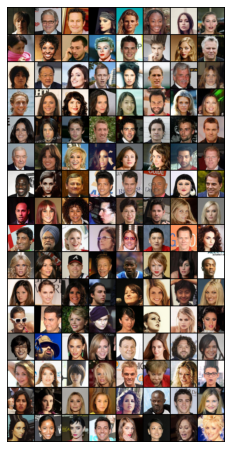

In [20]:
sample_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    sample_batch[0].to(device), padding=2, normalize=True).cpu(),
    (1,2,0)))

## Building The Model

According to the DCGAN paper, all model weights need to be randomly initialized from a Normal distribution with mean=0 and std.=0.02

In [39]:
# custom weight initializer
def init_weights(layer):
    name = layer.__class__.__name__
    if name.find('Conv') != -1:
        nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif name.find('BatchNorm') != -1:
        nn.init.normal_(layer.weight.data, 1.0, 0.02)
        nn.init.constant_(layer.bias.data, 0)

## Parameters

In [23]:
#Number of channels 
no_channels = 3

# Size of z latent vector 
latent_vector_size = 100

# Size of feature maps in generator
feature_map_gen_size = 64

# Size of feature maps in discriminator
feature_map_disc_size = 64

## Generator

In [35]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
        nn.ConvTranspose2d(latent_vector_size, feature_map_gen_size * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(feature_map_gen_size * 8),
        nn.ReLU(True),
        nn.ConvTranspose2d(feature_map_gen_size * 8, feature_map_gen_size * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_gen_size * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(feature_map_gen_size * 4, feature_map_gen_size * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_gen_size * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(feature_map_gen_size * 2, feature_map_gen_size, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_gen_size),
        nn.ReLU(True),
        nn.ConvTranspose2d(feature_map_gen_size, no_channels, 4, 2, 1, bias=False),
        nn.Tanh())
    
    def forward(self, input):
        return self.main(input)

we can now create a generator and initialize the weights

In [40]:
net_generator = Generator().to(device)
net_generator.apply(init_weights)
net_generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
        nn.Conv2d(no_channels, feature_map_disc_size, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(feature_map_disc_size, feature_map_disc_size * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_disc_size * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(feature_map_disc_size * 2, feature_map_disc_size * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_disc_size * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(feature_map_disc_size * 4, feature_map_disc_size * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(feature_map_disc_size * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(feature_map_disc_size * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid())
        
    def forward(self, input):
        return self.main(in)